# **Projet Python : Analyse des sentiments des usagers de la RATP**

**Introduction** : Il s'agit dans ce devoir, de scrapper un certain nombre de tweets concernant la RATP, en les séparant par RER et par heure, puis de s'intéresser à la satisfaction des usagers de ces transports. On se demande s'il y a des RER qui rencontrent une meilleure satisfaction que d'autres, si pour chaque RER il y a des différences selon l'heure, notamment aux heures de pointe.

# **Partie 1** : Création de la base de données

Pour notre étude nous utilisons une base de données constituée de tweets. Ces tweets sont scrappés directement decpuis twitter à l'aide du package tweepy, mis en place à cet effet. Il s'agit donc d'abord d'installer ce package et de s'identifier auprès de twitter afin qu'il autorise ce package à s'installer. Pour cela, nous avons créé un compte de twitter developer et nous avons utilisé nos clés d'accès. Dans la cellule de code ci-dessous, on importe également tous nos modules.

In [2]:
import tweepy
import pandas as pd
import csv
!pip install textblob
!pip install textblob-fr
from textblob_fr import PatternTagger, PatternAnalyzer
!pip install preprocessor
import preprocessor
import re
!pip install emoji
import emoji
import nltk
import numpy as np
import time
import datetime
from datetime import datetime
from textblob import TextBlob
import numpy as np
import matplotlib.pyplot as plt
!pip install gensim
import gensim

consumer_key = "9j7ncX7ohvlWjzDwcBW5iGdG8"
consumer_secret = "ddmGGCzD1gBmJN7w5sVp4dQSzWearFv9jLEYCdxbq4ARdKM9E6"
access_token = "1323999317204631553-PtK72rXBxm5Q7mccnTZU26pixBCmBP"
access_token_secret = "zKJRt7sKlwoTDw7dl8S1mzQf6Qv5rGrqVYiWxBortQJJ5"
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

  Created wheel for smart-open: filename=smart_open-4.0.1-py3-none-any.whl size=108253 sha256=0b577236bc3b97d768c63c15e1a4e7aa75f9b55effcbbbc67b7f829637fc7402
  Stored in directory: c:\users\duran\appdata\local\pip\cache\wheels\34\3d\14\f19c01a19c9201cdb6a76b049904d5226912569be919ad1eae
Successfully built smart-open
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.15
    Uninstalling Cython-0.29.15:
      Successfully uninstalled Cython-0.29.15


Nous décidons de scrapper les tweets à l'aide d'une recherche par mots clés. Cest tweets sont stockés sous forme de liste. La fonction get_tweet se base sur l'outil "api.search" qui scrappe tous les tweets contenant un certain mot-clé. Elle prend en argument le nombre de tweets que l'on veut scrapper contenant une certaine liste de mots clés. Cependant, il faut garder en tête que le principal inconvénient du module tweepy est qu'il limite beaucoup le nombre de tweets que l'on peut scrapper, donc on peut se retrouver avec moins de tweets que l'on souhaite. De plus, on choisit de ne prendre que les tweets publiés autour de Paris (dans l'argument geocode) pour éviter d'avoir des tweets créés par des robots à l'autre bout du monde qui viennent interférer, et cela ne nous limite pas aux tweets en français. (On pouvait régler le problème des robots en se limitant au français grâce à textblob mais il y a des gens non français qui peuvent tweeter sur la RATP donc choisir le géocode de Paris est la solution optimale). Il faut cependant prendre en compte que l'on aura sûrement une marge d'erreur pour le RER A. En effet, des usagers peuvent très bien tweeter en parlant d'un RER lambda "le RER a mal fonctionné ce matin" et il sera comptabilisé dans la liste des tweets sur le RER A. Nous n'avons pas trouvé comment contourner ce problème.

In [3]:
def get_tweet(key_words, n) :
  alltweets=[]
  for k in range(len(key_words)) :
    alltweets+=api.search(key_words[k], geocode='48.8534,2.3488,100km', count=n)
  return(alltweets)

liste_tweets_rer_A=get_tweet(["rer a"], 1000)
liste_tweets_rer_B=get_tweet(["rer b"], 1000)
liste_tweets_rer_C=get_tweet(["rer c"], 1000)
liste_tweets_rer_D=get_tweet(["rer D"], 1000)
liste_tweets_rer_E=get_tweet(["rer E"], 1000)

# **Partie 2** : Nettoyage des tweets


On nettoie ensuite les tweets. En effet, lorsque l'on scrappe Twitter, on a beaucoup d'informations qui ne nous intéressent pas. On veut juste le tweet et son heure. La fonction "extract_tweet" ci-dessous va nous retourner l'ensemble des tweets seuls, en enlevant toutes les informations dont nous ne voulons pas. De plus, on nettoie les tweets au passage. Cela signifie que l'on enlève les @, les emojis (en ayant installé au préalable le module emoji), les liens http. De plus, il faut enlever les RT de nos tweets car sinon on aurait le même tweet le nombre de fois qu'il aurait été retweeté, ce qui peut être beaucoup. La fonction removeduplicate est une verification finale pour supprimer les doublons.
Ensuite, on crée une fonction simple "heure_tweet" qui crée une liste remplie des heures des tweets que l'on vient de scrapper. Cela nous servira plus tard à tracer la satisfaction en fonction de l'heure.

In [4]:
def removeduplicate(liste):
  unique=[]
  for tweet in liste: 
    if tweet not in unique:
      unique.append(tweet)
  return unique

def extract_tweet(liste):
  tweets=[]
  twit='jeanne'
  for k in range(len(liste)) :
     twit=liste[k].text
     if twit[0]!='R' and twit[1]!='T' : #enlever les RT
       twit = re.sub("@[A-Za-z0-9]+","",twit) #enlever les @
       twit = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", twit) #enlever les http links
       twit = " ".join(twit.split())
       twit = ''.join(c for c in twit if c not in emoji.UNICODE_EMOJI) #enlever les emojis
       twit = twit.replace("#", "").replace("_", " ") #enlever les #
       twit = " ".join(w for w in nltk.wordpunct_tokenize(twit))
       twit=twit.lower() #mettre en minuscules
       tweets+=[twit]
       removeduplicate(tweets)
  return(tweets)

def heure_tweet(liste) :
  heures=[]
  liste2=removeduplicate(liste)
  for k in range(len(liste2)) :
    tweet=liste2[k].text
    if tweet[0]!='R' and tweet[1]!='T' :
      heures.append(liste2[k].created_at)
  return(heures)

liste_tweets_rer_A_propre=extract_tweet(liste_tweets_rer_A)
liste_tweets_rer_B_propre=extract_tweet(liste_tweets_rer_B)
liste_tweets_rer_C_propre=extract_tweet(liste_tweets_rer_C)
liste_tweets_rer_D_propre=extract_tweet(liste_tweets_rer_D)
liste_tweets_rer_E_propre=extract_tweet(liste_tweets_rer_E)

time_tweets_rer_A=heure_tweet(liste_tweets_rer_A)
time_tweets_rer_B=heure_tweet(liste_tweets_rer_B)
time_tweets_rer_C=heure_tweet(liste_tweets_rer_C)
time_tweets_rer_D=heure_tweet(liste_tweets_rer_D)
time_tweets_rer_E=heure_tweet(liste_tweets_rer_E)


Dans la section ci-dessous, nous présentons le code qui nous a permis d'établir notre base de donnée. Ce code a tourné dans un autre notebook, on le présente ici, mais utilisons la base produite par l'autre notebook. En effet, tweepy possède un inconvénient majeur, qui est qu'il limite le nombre de tweets qu'on peut scrapper. La limite est établie à 100. Nous avons donc scrappé 100 tweets plusieurs fois, et avons mis le tout sous forme de DataFrame puis de fichier CSV.

In [5]:
from google.colab import drive #module qui permet d'enregistrer sur le drive
drive.mount("drive", force_remount=True)

df_rerApropre=pd.DataFrame(liste_tweets_rer_A_propre) #transformation en dataframe
df_heureA=pd.DataFrame(time_tweets_rer_A)
df_rerA=pd.concat([df_rerApropre, df_heureA], axis=1)#concaténation des dataframe
df_rerA.columns=('tweet_RER_A','heure_du_tweet') 
df_rerA.to_csv('rerA0.csv')
!cp rerA0.csv "drive/My Drive/RER/"

df_rerBpropre=pd.DataFrame(liste_tweets_rer_B_propre) #transformation en dataframe
df_heureB=pd.DataFrame(time_tweets_rer_B)
df_rerB=pd.concat([df_rerBpropre, df_heureB], axis=1)#concaténation des dataframe 
df_rerB.columns=('tweet_RER_B','heure_du_tweet') 
df_rerB.to_csv('rerB0.csv')
!cp rerB0.csv "drive/My Drive/RER/"

df_rerCpropre=pd.DataFrame(liste_tweets_rer_C_propre) #transformation en dataframe
df_heureC=pd.DataFrame(time_tweets_rer_C)
df_rerC=pd.concat([df_rerCpropre, df_heureC], axis=1)#concaténation des dataframe 
df_rerC.columns=('tweet_RER_C','heure_du_tweet') 
df_rerC.to_csv('rerC0.csv')
!cp rerC0.csv "drive/My Drive/RER/"

df_rerDpropre=pd.DataFrame(liste_tweets_rer_D_propre) #transformation en dataframe
df_heureD=pd.DataFrame(time_tweets_rer_D)
df_rerD=pd.concat([df_rerDpropre, df_heureD], axis=1)#concaténation des dataframe 
df_rerD.columns=('tweet_RER_D','heure_du_tweet') 
df_rerD.to_csv('rerD0.csv')
!cp rerD0.csv "drive/My Drive/RER/"

df_rerEpropre=pd.DataFrame(liste_tweets_rer_E_propre) #transformation en dataframe
df_heureE=pd.DataFrame(time_tweets_rer_E)
df_rerE=pd.concat([df_rerEpropre, df_heureE], axis=1)#concaténation des dataframe 
df_rerE.columns=('tweet_RER_E','heure_du_tweet') 
df_rerE.to_csv('rerE0.csv')
!cp rerE0.csv "drive/My Drive/RER/"

ModuleNotFoundError: No module named 'google'

In [ ]:
!ls "drive/My Drive/RER/"

ls: cannot access 'drive/My Drive/RER/': No such file or directory


In [ ]:
dataA=[]
for k in range(8):
  dataA.append(pd.read_csv("drive/My Drive/RER/rerA"+str(k)+".csv"))

dataB=[]
for k in range(8):
  dataB.append(pd.read_csv("drive/My Drive/RER/rerB"+str(k)+".csv"))

dataC=[]
for k in range(8):
  dataC.append(pd.read_csv("drive/My Drive/RER/rerC"+str(k)+".csv"))

dataD=[]
for k in range(8):
  dataD.append(pd.read_csv("drive/My Drive/RER/rerD"+str(k)+".csv"))

dataE=[]
for k in range(8):
  dataE.append(pd.read_csv("drive/My Drive/RER/rerE"+str(k)+".csv"))

FileNotFoundError: ignored

In [ ]:
frameA = pd.concat(dataA, axis=0, ignore_index=True)
frameA=frameA.drop(frameA.columns[0], axis='columns')

frameB = pd.concat(dataB, axis=0, ignore_index=True)
frameB=frameB.drop(frameB.columns[0], axis='columns')

frameC = pd.concat(dataC, axis=0, ignore_index=True)
frameC=frameC.drop(frameC.columns[0], axis='columns')

frameD = pd.concat(dataD, axis=0, ignore_index=True)
frameD=frameD.drop(frameD.columns[0], axis='columns')

frameE = pd.concat(dataE, axis=0, ignore_index=True)
frameE=frameE.drop(frameE.columns[[0,3]], axis='columns')



ValueError: ignored

In [ ]:
frameA.to_csv('rerA.csv')
!cp rerA.csv "drive/My Drive/RER/"

frameB.to_csv('rerB.csv')
!cp rerB.csv "drive/My Drive/RER/"

frameC.to_csv('rerC.csv')
!cp rerC.csv "drive/My Drive/RER/"

frameD.to_csv('rerD.csv')
!cp rerD.csv "drive/My Drive/RER/"

frameE.to_csv('rerE.csv')
!cp rerE.csv "drive/My Drive/RER/"

# **Partie 3 :** Analyse de sentiment

On va maintenant chercher à calculer les sentiments d'une ligne précise de RER à une heure précise. Pour cela on commence par créer la fonction concatenation ci-dessous. Elle va permettre de transformer une liste de tweets en une seule phrase géante. Cela rend la fonction de sentiment de textblob plus précise. En effet, ensuite, on crée la fonction "sentiment1". Elle analyse les sentiments d'une ligne une heure précise que si l'on calculait le sentiment de chaque tweet et que l'on faisait ensuite une moyenne des sentiments car les tweets contiennent peu de mots. Ainsi, plutôt que d'appliquer la fonction sentiment.polarity de textblob à chaque tweet, on va l'appliquer à la phrase géante contenant l'ensemble des tweets pour avoir directement le sentiment moyen des tweets sur cette ligne à cette heure précise.

In [ ]:
def concatenation(liste) :
  liste_geante=[]
  string=''
  for tweet in liste :
    string+=tweet
  liste_geante.append(string)
  return(liste_geante)

In [ ]:
def sentiment1(liste_tweets, liste_heures, heure) :
  h1=heure
  h2=heure+1
  liste_tweets_heure=[]
  for k in range(len(liste_heures)) :
    if liste_heures[k].hour>=h1 and liste_heures[k].hour<=h2 : #pour ne garder que les tweets produits à cette heure-là
      liste_tweets_heure+=liste_tweets[k]
  liste_tweets_heure=concatenation(liste_tweets_heure)
  blob=TextBlob(liste_tweets_heure[0])
  return(blob.sentiment.polarity)

On va maintenant ouvrir les fichiers csv que l'on a stockés dans notre drive pour pouvoir analyser les sentiments de nos listes de tweets (qui sont désormais plus grandes que ce que api.search nous avait donné).

In [ ]:
tweets_A=[]
heures_A=[]
crA=csv.reader(open('rerA.csv', 'r'))
for row in crA : 
  if row[2]!='heure_du_tweet' :
    tweets_A.append(row[1])
    heures_A.append(datetime.strptime(row[2], "%Y-%m-%d %H:%M:%S"))

tweets_B=[]
heures_B=[]
crB=csv.reader(open('rerB.csv', 'r'))
for row in crB : 
  if row[2]!='heure_du_tweet' :
    tweets_B.append(row[1])
    heures_B.append(datetime.strptime(row[2], "%Y-%m-%d %H:%M:%S"))

tweets_C=[]
heures_C=[]
crC=csv.reader(open('rerC.csv', 'r'))
for row in crC : 
  if row[2]!='heure_du_tweet' : 
    tweets_C.append(row[1])
    heures_C.append(datetime.strptime(row[2], "%Y-%m-%d %H:%M:%S"))

tweets_D=[]
heures_D=[]
crD=csv.reader(open('rerD.csv', 'r'))
for row in crD : 
  if row[2]!='heure_du_tweet' : 
    tweets_D.append(row[1])
    heures_D.append(datetime.strptime(row[2], "%Y-%m-%d %H:%M:%S"))

tweets_E=[]
heures_E=[]
crE=csv.reader(open('rerE.csv', 'r'))
for row in crE : 
  if row[2]!='heure_du_tweet' : 
    tweets_E.append(row[1])
    heures_E.append(datetime.strptime(row[2], "%Y-%m-%d %H:%M:%S"))

FileNotFoundError: ignored

In [ ]:
sentiment1(tweets_C, heures_C, 7)

-0.525

On a donc pris en exemple, ci-dessus, la satisfaction des usagers du RER C à 7h, heure de pointe. sentiment.polarity est une fonction qui va de -1 à 1, ainsi on peut en déduire qu'à 7h, les usagers du RER A étaient globalement non satisfaits du service. On va maintenant chercher à tracer la satisfaction en fonction de l'heure.

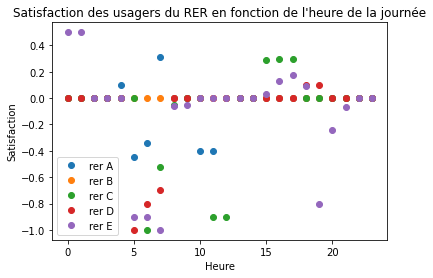

In [ ]:
heures=[k for k in range(24)]
satisfaction_rer_A=[sentiment1(tweets_A, heures_A, k) for k in range(24)]
satisfaction_rer_B=[sentiment1(tweets_B, heures_B, k) for k in range(24)]
satisfaction_rer_C=[sentiment1(tweets_C, heures_C, k) for k in range(24)]
satisfaction_rer_D=[sentiment1(tweets_D, heures_D, k) for k in range(24)]
satisfaction_rer_E=[sentiment1(tweets_E, heures_E, k) for k in range(24)]
plt.plot(heures,satisfaction_rer_A, 'o', label='rer A')
plt.plot(heures,satisfaction_rer_B, 'o', label= 'rer B')
plt.plot(heures,satisfaction_rer_C, 'o', label= 'rer C')
plt.plot(heures,satisfaction_rer_D, 'o', label= 'rer D')
plt.plot(heures,satisfaction_rer_E, 'o', label= 'rer E')
plt.xlabel('Heure')
plt.ylabel('Satisfaction')
plt.title("Satisfaction des usagers du RER en fonction de l'heure de la journée")
plt.legend()
plt.show()

On a donc ci-dessus un graphique illustrant la satisfaction des usagers du RER en fonction de l'heure de la journée. Plus on est proches de -1, moins les usagers sont satisfaits. A l'inverse, plus on se rapproche de 1, plus ils le sont. La satisfaction varie beaucoup selon l'heure, ont peut constater par exemple que le matin les usagers du RER A sont très insatisfaits du service qui leur est proposé, et les usagers du RER B sont en moyenne plutôt mécontents car ils dépassent rarement la barre du 0. En moyenne on peut remarquer que l'on est plus souvent du côté négatif que positif et que les tweets positifs ne sont pas autant poussés que les tweets négatifs (en effet, on va souvent vers -1 alors qu'on dépasse rarement 0,5).  Cependant, on peut constater que l'on manque un peu de données. En effet, lorsque le niveau de satisfaction est à 0 pile, on peut penser qu'il y avait très peu voire pas de tweets sur le RER en question à cette heure là. C'est notamment le cas du RER E, les usagers ont l'air de faire peu de tweets à son sujet. Le schéma qui a l'air de revenir est une insatisfaction aux heures de pointe et les passagers sont neutres voire plutôt satisfaits le reste du temps.

On essaye ensuite de créer notre propre fonction d'analyse de sentiments des tweets. En effet nous ne savons pas à quel points les tweets peuvent utiliser du vocabulaire que sentiment.polarity ne saura pas prendre en compte. Ainsi, on va chercher à créer une fonction qui va repérer les tweets négatifs, ou plutôt les mots négatifs qu'ils contiennent. Pour cela, elle utilisera simplement un compteur de mots négatifs qui viennent d'une liste que l'on a créée et qui couvre un grand nombre de mots négatifs qui peuvent être dits à propos des transports. Ainsi avec notre nouvelle fonction, plus on obtient un score élevé, plus il y a eu de tweets négatifs sur une certaine ligne. On va également tracer la satisfaction en fonction de l'heure avec notre nouvelle fonction et comparer le résultat à celui obtenu précédemment.

In [ ]:
mots_negatifs=["retard", "blindé", "bondé", "panne", "haine", "seum", "souci", "soucis", "problème", "problèmes", "malaise", "monde", "danger", "chaud", "voleur", "agression", "frotteur", "sexuel", "controler", "debout", "putain", "nsm", "ptn","bagage", "incident", "contrôleurs","perturbé", "sale", "dégradé", "puant", "pue", "crade", "attente", "pute", "long", "longtemps", "plombes", "chiant", "merde", "relou", "perturbations", "interrompu", "colis", "suspect"]

def sentiment_construit(tweet) :
  phrase=tweet.split()
  compteur=0
  for k in range(len(phrase)) :
    if phrase[k] in mots_negatifs :
      compteur+=1
  return(compteur)

def score(liste) :
  S=0
  for tweet in liste :
    S+=sentiment_construit(tweet)
  return(S)

def sentiment2(liste_tweets, liste_heures, heure) :
  h1=heure
  h2=heure+1
  liste_tweets_heure=[]
  for k in range(len(liste_heures)) :
    if liste_heures[k].hour>=h1 and liste_heures[k].hour<=h2 : 
      liste_tweets_heure.append(liste_tweets[k])
  return(score(liste_tweets_heure))


Nous allons montrer un exemple d'utilisation de notre fonction sentiment_construit en utilisant une phrase négative possible exprimée à propos du RER.

In [ ]:
sentiment_construit("RER de merde c'était blindé j'étais debout pendant des plombes")

4

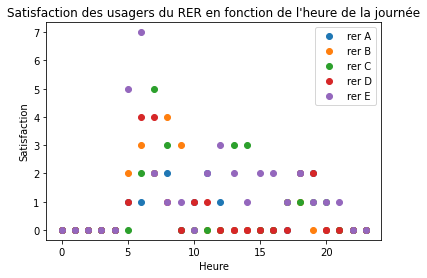

In [ ]:
heures=[k for k in range(24)]
satisfaction_rer_A_2=[sentiment2(tweets_A, heures_A, k) for k in range(24)]
satisfaction_rer_B_2=[sentiment2(tweets_B, heures_B, k) for k in range(24)]
satisfaction_rer_C_2=[sentiment2(tweets_C, heures_C, k) for k in range(24)]
satisfaction_rer_D_2=[sentiment2(tweets_D, heures_D, k) for k in range(24)]
satisfaction_rer_E_2=[sentiment2(tweets_E, heures_E, k) for k in range(24)]
plt.plot(heures,satisfaction_rer_A_2, 'o', label='rer A')
plt.plot(heures,satisfaction_rer_B_2, 'o', label= 'rer B')
plt.plot(heures,satisfaction_rer_C_2, 'o', label= 'rer C')
plt.plot(heures,satisfaction_rer_D_2, 'o', label= 'rer D')
plt.plot(heures,satisfaction_rer_E_2, 'o', label= 'rer E')
plt.xlabel('Heure')
plt.ylabel('Satisfaction')
plt.title("Satisfaction des usagers du RER en fonction de l'heure de la journée")
plt.legend()
plt.show()

On constate quand même qu'il y a un niveau d'insatisfaction général puisqu'il y a peu de tweets qui restent à 0 alors que dans notre fonction, contrairement à celle de textblob, 0 représente le neutre et le positif. Ainsi, à part pour le RER E qui manque de tweets à son sujet, on voit bien que l'on atteint des scores plutôt élevés sur chaque ligne, notamment à l'heure de pointe du matin, ce qui témoigne d'un mécontentement global des services publics de transport. On a l'impression que cette méthode recense plus la négativité que la fonction de texblob, certainement parce qu'on a intégré du vocabulaire plus utilisé sur Internet que celui de sentiment1. Cependant, elle reste légèrement imprécise car on ne peut pas couvrir les tweets positifs. Nous avons choisi de ne pas avoir de compteur de mots positifs pour éviter de prendre en compte des tweets ironiques dans les tweets positifs. En effet, on pourrait très bien avoir un usager qui tweete "Génial le RER ce matin" de manière ironique et il serait perçu comme un tweet positif. C'est un problème que rencontre sûrement la fonction sentiment1 aussi.

Pour compléter ce qu'on pourrait observer sur le graphe, on se décide à effectuer une régression linéaire de la satisfaction sur l'heure pour chaque rer, avec le module sklearn. 

In [ ]:
XA= satisfaction_rer_A_2 
XB= satisfaction_rer_B_2
XC= satisfaction_rer_C_2
XD= satisfaction_rer_D_2
XE= satisfaction_rer_E_2
Y = heures

regA = LinearRegression().fit(XA, Y)
regB = LinearRegression().fit(XB, Y)
regC = LinearRegression().fit(XC, Y)
regD = LinearRegression().fit(XD, Y)
regE = LinearRegression().fit(XE, Y)

print (regA.score(XA,Y), regB.score(XB,Y), regC.score(XC,Y), regD.score(XD,Y), regE.score(XE,Y) )

NameError: ignored

In [ ]:
from google.colab import drive
drive.mount("drive", force_remount=True)

KeyboardInterrupt: ignored

In [ ]:
import word2vec
vocabulaire = KeyedVectors.load_word2vec_format('http://embeddings.net/frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin', binary=True)
!cp vocabulaire "drive/My Drive/"


     |████████████████████████████████| 51kB 2.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for word2vec: filename=word2vec-0.11.1-cp36-none-any.whl size=156401 sha256=907d1479f712da5327cc10b398338e1d4034d47985f8f59929d25b9814fb9386
  Stored in directory: /root/.cache/pip/wheels/f3/7c/ac/fcb6d867f806021c3730fd848970db988b1d0030b5d20c0e02
Successfully built word2vec
cp: cannot stat 'vocabulaire': No such file or directory


In [ ]:
def vecteur(liste) :
  V=[]
  vec_tweet=[]
  for tweet in liste :
    phrase=[]
    vec_tweet=[]
    phrase+=tweet.split()
    for mot in phrase :
      vec_tweet+=vocabulaire.word_vec(mot)
    V.append(np.mean(vec_tweet,0))
  return(V) 

vecteur(["Je aime les pommes", "Je vais bien"])

KeyError: ignored

# **Partie 4 :** Réponse automatique à un tweet négatif

il me semble qu'avec tweepy on peut créer un bot de réponse. 
En soi on peut juste faire un if then repondre "quel est votre soucis, nous sommes désolés de votre insatisfaction".
ou faire qq chose de plus élaborer mais ej sais pas quoi